In [60]:
import seaborn as sns
import numpy as np
import pandas as pd

import pickle
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.model_selection import ParameterGrid
from scipy.spatial.distance import cdist
from sklearn.metrics import silhouette_score
from sklearn.decomposition import NMF


In [61]:
with open('preprocessed_data/original_data.pkl', 'rb') as f:
    data = pickle.load(f)
    print(data)
    print(len(data))
    


      has_null  wave  gender   age  age_o  d_age  d_d_age  race  race_o  \
0          0.0   1.0     0.0  21.0   27.0    6.0      2.0   0.0     3.0   
1          0.0   1.0     0.0  21.0   22.0    1.0      0.0   0.0     3.0   
2          1.0   1.0     0.0  21.0   22.0    1.0      0.0   0.0     0.0   
3          0.0   1.0     0.0  21.0   23.0    2.0      1.0   0.0     3.0   
4          0.0   1.0     0.0  21.0   24.0    3.0      1.0   0.0     2.0   
...        ...   ...     ...   ...    ...    ...      ...   ...     ...   
8373       1.0  21.0     1.0  25.0   26.0    1.0      0.0   3.0     2.0   
8374       1.0  21.0     1.0  25.0   24.0    1.0      0.0   3.0     4.0   
8375       1.0  21.0     1.0  25.0   29.0    4.0      2.0   3.0     2.0   
8376       1.0  21.0     1.0  25.0   22.0    3.0      1.0   3.0     0.0   
8377       1.0  21.0     1.0  25.0   22.0    3.0      1.0   3.0     0.0   

      samerace  ...  field_14  field_15  field_16  field_17  race_0.0  \
0          0.0  ...       

#### Show correlation between self-reported scores and scores given by the opponent 

              attractive  attractive_o
attractive      1.000000      0.351675
attractive_o    0.351675      1.000000
            sincere  sinsere_o
sincere    1.000000  -0.060649
sinsere_o -0.060649   1.000000
            funny   funny_o
funny    1.000000  0.022237
funny_o  0.022237  1.000000
            ambition  ambitous_o
ambition    1.000000    0.272526
ambitous_o  0.272526    1.000000
                intelligence  intelligence_o
intelligence        1.000000        0.014691
intelligence_o      0.014691        1.000000


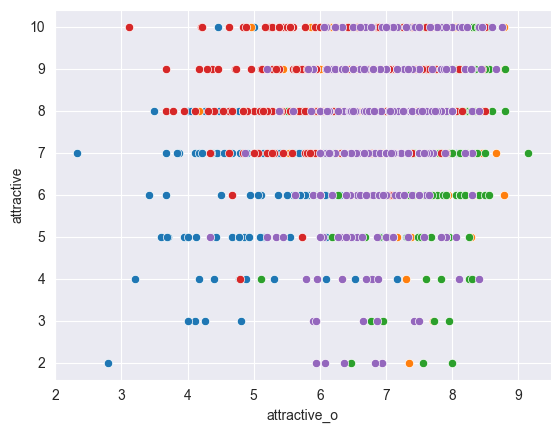

In [62]:
self_rated_features = ['attractive', 'sincere', 'intelligence', 'funny', 'ambition']
average_columns = [ 'attractive_o', 'sinsere_o', 'intelligence_o', 'funny_o', 'ambitous_o']
group_by_columns = ['gender', 'age', 'race', 'field', 'attractive_important', 'sincere_important', 'intellicence_important', 'funny_important', 'ambtition_important', 'shared_interests_important', 'attractive', 'sincere', 'intelligence', 'funny', 'ambition', 'sports', 'tvsports', 'exercise', 'dining', 'museums', 'art', 'hiking', 'gaming', 'clubbing', 'reading', 'tv', 'theater', 'movies', 'concerts', 'music', 'shopping', 'yoga']

def compare_ratings(data):
    combined_df = (
    data.groupby(group_by_columns, as_index=False)
    [average_columns].mean()
    )
    reduced_df = combined_df[self_rated_features + average_columns]
    
    corr_attractive = reduced_df[['attractive', 'attractive_o']].corr()
    corr_sincere = reduced_df[['sincere', 'sinsere_o']].corr()
    corr_intelligence = reduced_df[['intelligence', 'intelligence_o']].corr()
    corr_funny = reduced_df[['funny', 'funny_o']].corr()
    corr_ambition = reduced_df[['ambition', 'ambitous_o']].corr()
    
    print(corr_attractive)
    print(corr_sincere)
    print(corr_funny)
    print(corr_ambition)
    print(corr_intelligence)
    
    sns.scatterplot(reduced_df, x="attractive_o", y="attractive")
    sns.scatterplot(reduced_df, x="sinsere_o", y="sincere")
    sns.scatterplot(reduced_df, x="intelligence_o", y="intelligence")
    sns.scatterplot(reduced_df, x="funny_o", y="funny")
    sns.scatterplot(reduced_df, x="ambitous_o", y="ambition")  
   
    

women = data.loc[data['gender'] == 0]
men = data.loc[data['gender'] == 1]

compare_ratings(men)  


    

In [63]:
def remove_relational_data(data):
    data = data[['gender', 'age', 'race', 'field', 'attractive_o', 'sinsere_o', 'intelligence_o', 'funny_o', 'ambitous_o', 'shared_interests_o', 'attractive_important', 'sincere_important', 'intellicence_important', 'funny_important', 'ambtition_important', 'shared_interests_important', 'attractive', 'sincere', 'intelligence', 'funny', 'ambition', 'sports', 'tvsports', 'exercise', 'dining', 'museums', 'art', 'hiking', 'gaming', 'clubbing', 'reading', 'tv', 'theater', 'movies', 'concerts', 'music', 'shopping', 'yoga', 'shared_interests_o']]
    return data

data = remove_relational_data(data)    

In [64]:
combined_df = (
    data.groupby(group_by_columns, as_index=False)
    [average_columns].mean()
)

In [65]:
# Select women
combined_df = combined_df.loc[combined_df['gender'] == 0]

# Select men
#combined_df = combined_df.loc[combined_df['gender'] == 1]

##### Normalize features

In [66]:
from sklearn.preprocessing import MinMaxScaler

#Remove categorical values
features = combined_df.drop(labels=['race', 'field'], axis=1)

n_features = len(features.columns)
std_scaler = StandardScaler()
normalized_features = std_scaler.fit_transform(features)
min_max_scaler = MinMaxScaler()
normalized_features = min_max_scaler.fit_transform(normalized_features)
print(normalized_features.shape)

(271, 35)


##### Apply PCA

In [67]:
pca_reduced_features = []
for n in range(2,15):
    pca = PCA(n_components=n)
    reduced_features = pca.fit_transform(normalized_features)
    pca_reduced_features.append(reduced_features)
    print('Cumulative variance explained by {} principal components: {:.2%}'.format(n, np.sum(pca.explained_variance_ratio_)))


Cumulative variance explained by 2 principal components: 24.20%
Cumulative variance explained by 3 principal components: 33.86%
Cumulative variance explained by 4 principal components: 41.79%
Cumulative variance explained by 5 principal components: 47.23%
Cumulative variance explained by 6 principal components: 52.30%
Cumulative variance explained by 7 principal components: 57.03%
Cumulative variance explained by 8 principal components: 60.94%
Cumulative variance explained by 9 principal components: 64.49%
Cumulative variance explained by 10 principal components: 67.86%
Cumulative variance explained by 11 principal components: 71.06%
Cumulative variance explained by 12 principal components: 73.96%
Cumulative variance explained by 13 principal components: 76.64%
Cumulative variance explained by 14 principal components: 79.01%


##### Apply NMF

In [68]:
nmf_reduced_features = []
for n in range(2,15):
    nmf_model = NMF(n_components=n, init='random', random_state=0, max_iter=5000)  # 3
    nmf_features = nmf_model.fit_transform(normalized_features)
    nmf_reduced_features.append(nmf_features)
    H = nmf_model.components_
    print('Frobenius norm as reconstruction error by {} components: {:.2%}'.format(n, nmf_model.reconstruction_err_))
    


Frobenius norm as reconstruction error by 2 components: 1790.33%
Frobenius norm as reconstruction error by 3 components: 1680.23%
Frobenius norm as reconstruction error by 4 components: 1575.22%
Frobenius norm as reconstruction error by 5 components: 1504.33%
Frobenius norm as reconstruction error by 6 components: 1431.25%
Frobenius norm as reconstruction error by 7 components: 1361.45%
Frobenius norm as reconstruction error by 8 components: 1296.29%
Frobenius norm as reconstruction error by 9 components: 1234.99%
Frobenius norm as reconstruction error by 10 components: 1174.10%
Frobenius norm as reconstruction error by 11 components: 1113.29%
Frobenius norm as reconstruction error by 12 components: 1059.01%
Frobenius norm as reconstruction error by 13 components: 1008.58%
Frobenius norm as reconstruction error by 14 components: 957.39%


### K-means - Partitional Clustering Techniques

#### Generalized fitting and tuning function

In [69]:
def tune_model(parameter_grid, model, data, show_silhouette, isKmeans):
    if isKmeans:
        distortions = []
        inertias = []
        
        mapping1=  {}  
        mapping2=  {}    

    best_score = -1        
    silhouette_scores = []
    
    # evaluation based on silhouette_score
    for p in parameter_grid:
        model.set_params(**p)    # Set current hyperparameters
        model.fit(data) 
        
        if len(set(model.labels_)) > 2:
            ss = silhouette_score(data, model.labels_)   
            silhouette_scores += [ss]     
            if show_silhouette:
                print('Parameter:', p, 'Score', ss)
            
            if isKmeans:
                distortions.append(sum(np.min(cdist(data, model.cluster_centers_, 'euclidean'), axis=1)**2) / data.shape[0])      
                inertias.append(model.inertia_)
            
                k = p['n_clusters']
                # Store the mappings for easy access
                mapping1[k] = distortions[-1]
                mapping2[k] = inertias[-1]
                # check p which has the best score
            
            if ss > best_score:
                best_score = ss
                best_grid = p
        
    if show_silhouette:      
        # plotting silhouette score
        plt.bar(range(len(silhouette_scores)), list(silhouette_scores), align='center', color='#722f59', width=0.5)
        plt.xticks(range(len(silhouette_scores)), range(len(list(silhouette_scores))))
        plt.title('Silhouette Score', fontweight='bold')
        plt.xlabel('Number of Clusters')
        plt.show()
    
    if isKmeans:
        print("Distortion values:")
        for key, val in mapping1.items():
            print(f'{key} : {val}')
        # Plotting the graph of k versus Distortion
        plt.plot(parameters, distortions, 'bx-')
        plt.xlabel('Number of Clusters (k)')
        plt.ylabel('Distortion')
        plt.title('The Elbow Method using Distortion')
        plt.grid()
        plt.show()
        
        print("Inertia values:")
        for key, val in mapping2.items():
            print(f'{key} : {val}')
        # Plotting the graph of k versus Inertia
        plt.plot(parameters, inertias, 'bx-')
        plt.xlabel('Number of Clusters (k)')
        plt.ylabel('Inertia')
        plt.title('The Elbow Method using Inertia')
        plt.grid()
        plt.show()   

In [70]:
### Only the KMeans model can set the last parameter (isKmeans) of tune_model to True, as only the Kmeans model has an inertia and distortion attribute
    
model = KMeans()
parameters = range(2,15)
parameter_grid = ParameterGrid({'n_clusters': parameters, 'n_init': ['auto']})

tune_model(parameter_grid, model, combined_df, False, False)
tune_model(parameter_grid, model, normalized_features, False, False)
for rf in pca_reduced_features:
    tune_model(parameter_grid, model, rf, False, False)
for nmf in nmf_reduced_features:
    tune_model(parameter_grid, model, nmf, False, False)

### Hierarchical Clustering

Parameter: {'linkage': 'ward', 'n_clusters': 3} Score 0.3924406249462126
Parameter: {'linkage': 'ward', 'n_clusters': 4} Score 0.36911943872776626
Parameter: {'linkage': 'ward', 'n_clusters': 5} Score 0.2672998174295227
Parameter: {'linkage': 'ward', 'n_clusters': 6} Score 0.24441488388196106
Parameter: {'linkage': 'ward', 'n_clusters': 7} Score 0.2573526849641057
Parameter: {'linkage': 'ward', 'n_clusters': 8} Score 0.22333675125394334
Parameter: {'linkage': 'ward', 'n_clusters': 9} Score 0.20059545315802982
Parameter: {'linkage': 'ward', 'n_clusters': 10} Score 0.20190070649882838
Parameter: {'linkage': 'ward', 'n_clusters': 11} Score 0.17925557830040242
Parameter: {'linkage': 'ward', 'n_clusters': 12} Score 0.1751127147166289
Parameter: {'linkage': 'ward', 'n_clusters': 13} Score 0.17842932060905145
Parameter: {'linkage': 'ward', 'n_clusters': 14} Score 0.179979384528607
Parameter: {'linkage': 'complete', 'n_clusters': 3} Score 0.4426966459765919
Parameter: {'linkage': 'complete', '

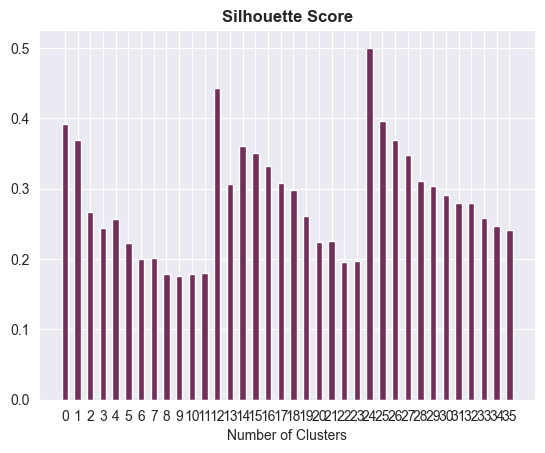

Parameter: {'linkage': 'ward', 'n_clusters': 3} Score 0.04762971603086855
Parameter: {'linkage': 'ward', 'n_clusters': 4} Score 0.05135461675972104
Parameter: {'linkage': 'ward', 'n_clusters': 5} Score 0.02889388439259699
Parameter: {'linkage': 'ward', 'n_clusters': 6} Score 0.03051123153899928
Parameter: {'linkage': 'ward', 'n_clusters': 7} Score 0.027605741786251504
Parameter: {'linkage': 'ward', 'n_clusters': 8} Score 0.033860681105276874
Parameter: {'linkage': 'ward', 'n_clusters': 9} Score 0.029998324726376403
Parameter: {'linkage': 'ward', 'n_clusters': 10} Score 0.028761395650678957
Parameter: {'linkage': 'ward', 'n_clusters': 11} Score 0.032598581416311966
Parameter: {'linkage': 'ward', 'n_clusters': 12} Score 0.03603775766412421
Parameter: {'linkage': 'ward', 'n_clusters': 13} Score 0.03806324336568639
Parameter: {'linkage': 'ward', 'n_clusters': 14} Score 0.03728827760597086
Parameter: {'linkage': 'complete', 'n_clusters': 3} Score 0.043688516997393075
Parameter: {'linkage': 

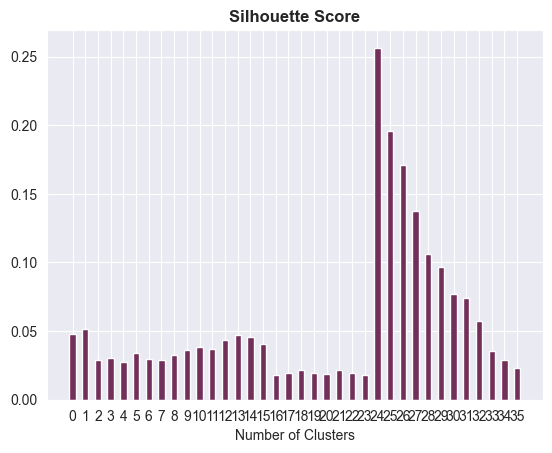

In [74]:
parameters = range(2,15)
parameter_grid = ParameterGrid({'n_clusters': parameters , 'linkage':['ward', 'complete', 'average']})
agglom = AgglomerativeClustering() 

tune_model(parameter_grid, agglom, combined_df, True, False)
tune_model(parameter_grid, agglom, normalized_features, True, False)


### DBSCAN

In [72]:
dbscan = DBSCAN()
eps = [0.01, 0.2, 0.5, 0.9, 1, 10, 20, 100]
min_samples = [2, 5, 10]

parameter_grid = ParameterGrid({'eps':eps, 'min_samples':min_samples})

tune_model(parameter_grid, dbscan, combined_df, False, False)
tune_model(parameter_grid, dbscan, normalized_features, False, False)

